In [8]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

In [9]:
result_df = pd.read_csv("results.csv")
result_df.head()

,framework,model,dataset,quantization,accuracy,std_err
0,paper,Llama-2-7b,winogrande,NaN,0.6920,NaN
1,paper,Llama-2-7b,arc_easy,NaN,0.7520,NaN
2,paper,Llama-2-7b,arc_challenge,NaN,0.4590,NaN
3,paper,Llama-2-7b,truthfulqa_mc,NaN,0.3329,NaN
4,paper,Llama-2-7b,hellaswag,NaN,0.7720,NaN


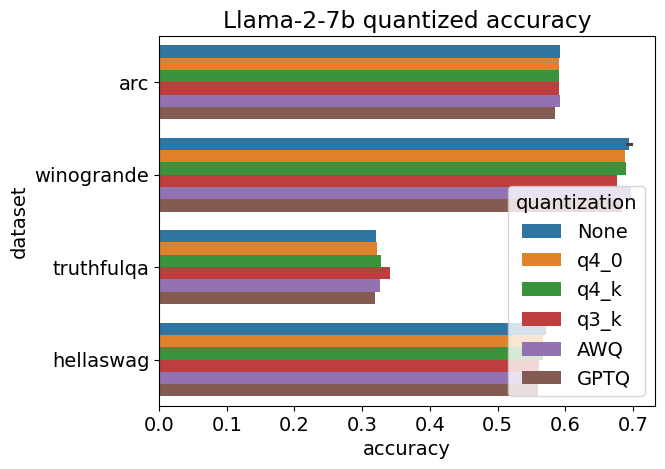

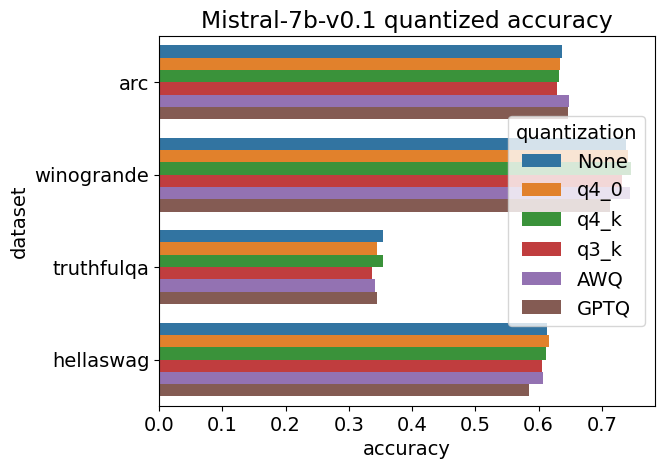

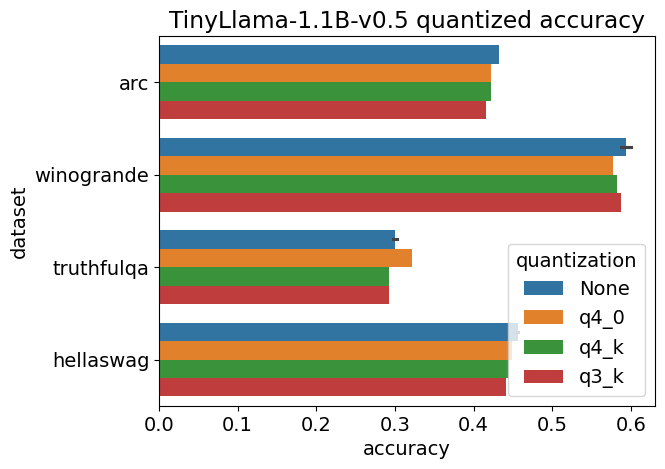

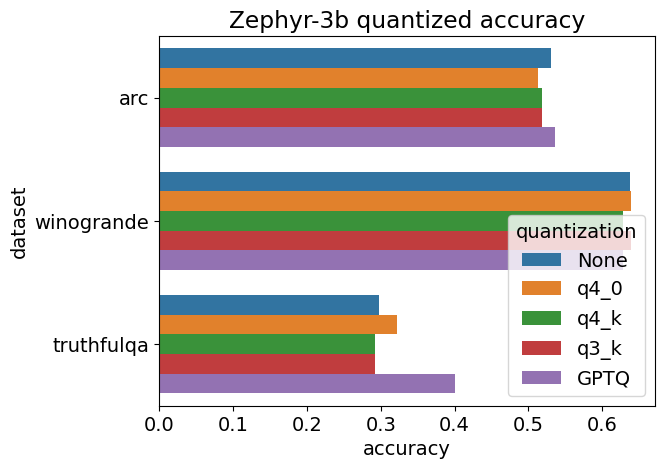

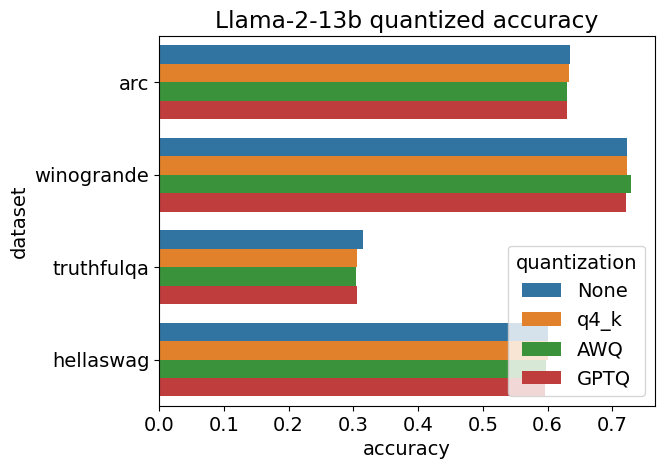

In [10]:
# model results
models = result_df["model"].unique()

for model_name in models:
  llama_df = result_df[result_df["model"] == model_name]
  llama_df = llama_df[llama_df["framework"] != "paper"]
  llama_df = llama_df[llama_df["dataset"].isin(["winogrande", "arc", "truthfulqa", "hellaswag"])]
  llama_df.loc[llama_df["quantization"].isna(),"quantization"] = "None"
  llama_df = llama_df[llama_df["quantization"].isin(["q4_0", "q4_k", "q3_k", "AWQ", "GPTQ", "None"])]
  ax = sns.barplot(x="accuracy", y="dataset", hue="quantization", hue_order=[label for label in ["None", "q4_0", "q4_k", "q3_k", "AWQ", "GPTQ"] if label in llama_df.quantization.unique()], data=llama_df, orient='h')
  ax.set_title(f"{model_name} quantized accuracy")
  plt.savefig(f"figures/{model_name}_quantized_accuracy.png", dpi=300, bbox_inches='tight')
  plt.show()

In [11]:
specs_df = pd.read_csv("model_specs.csv")
specs_df.loc[specs_df["quantization"].isna(),"quantization"] = "None"
specs_df.head()

,model,quantization,size,size_in_memory,parameters,max_ram
0,Mistral-7b-v0.1,None,14.48,13.49,7240000,NaN
1,Mistral-7b-v0.1,q3_k,3.52,3.28,7240000,6.02
2,Mistral-7b-v0.1,q4_k,4.37,4.07,7240000,6.87
3,Mistral-7b-v0.1,q4_0,4.11,3.83,7240000,6.61
4,Mistral-7b-v0.1,AWQ,4.15,4.47,7240000,NaN


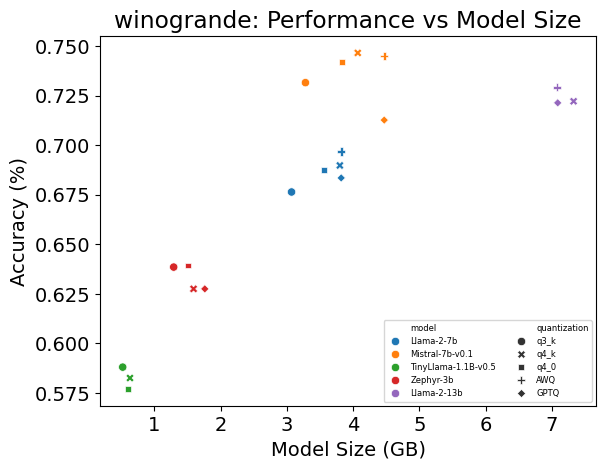

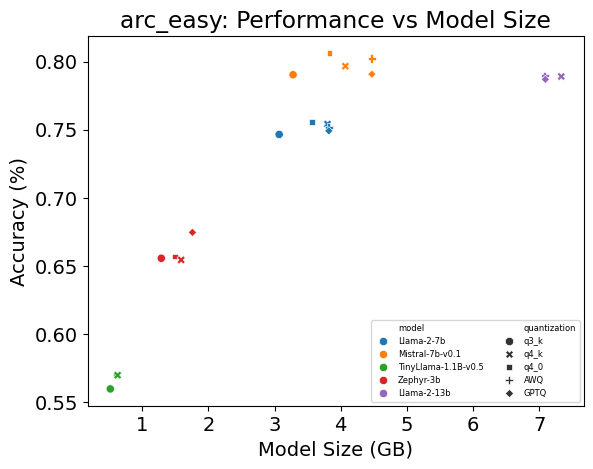

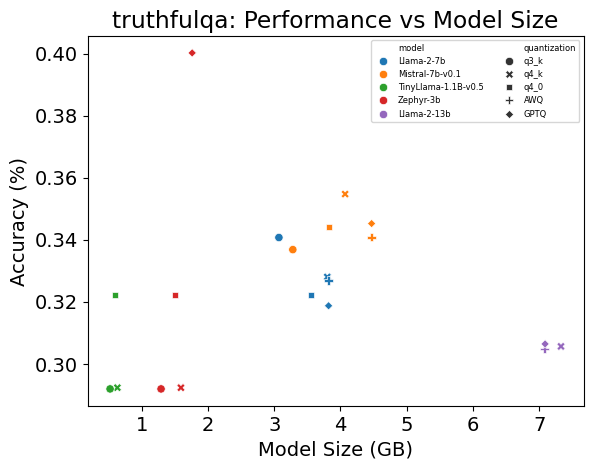

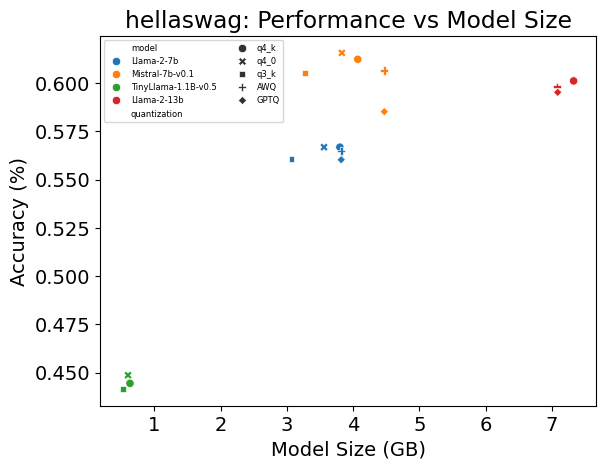

In [12]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Filter the dataframe for the desired datasets
datasets = ["winogrande", "arc_easy", "truthfulqa", "hellaswag"]
filtered_df = result_df[result_df["dataset"].isin(datasets)]
filtered_df = filtered_df[filtered_df["framework"] != "paper"]

# Create a separate plot for each dataset
for dataset in datasets:
  dataset_df = filtered_df[filtered_df["dataset"] == dataset]
  #dataset_df.loc[dataset_df["quantization"].isna(),"quantization"] = "None"
  dataset_df = dataset_df.merge(specs_df, on=("model","quantization"))

  # Create a single plot for the model in the dataset
  plt.figure()
  ax = sns.scatterplot(x="size_in_memory", y="accuracy", hue="model", style="quantization", data=dataset_df)

  ax.set_title(f"{dataset}: Performance vs Model Size")
  ax.set_xlabel("Model Size (GB)")
  ax.set_ylabel("Accuracy (%)")
  ax.legend(prop={'size': 6}, ncol=2)
  plt.savefig(f"figures/{dataset}_performance_vs_size.pdf", dpi=300, bbox_inches='tight')
  plt.show()

In [13]:
result_df.replace(np.nan, "None", inplace=True)
specs_df.replace(np.nan, "None", inplace=True)
display(result_df.head(5))
display(specs_df.head(5))

,framework,model,dataset,quantization,accuracy,std_err
0,paper,Llama-2-7b,winogrande,None,0.692,None
1,paper,Llama-2-7b,arc_easy,None,0.752,None
2,paper,Llama-2-7b,arc_challenge,None,0.459,None
3,paper,Llama-2-7b,truthfulqa_mc,None,0.3329,None
4,paper,Llama-2-7b,hellaswag,None,0.772,None


,model,quantization,size,size_in_memory,parameters,max_ram
0,Mistral-7b-v0.1,None,14.48,13.49,7240000,None
1,Mistral-7b-v0.1,q3_k,3.52,3.28,7240000,6.02
2,Mistral-7b-v0.1,q4_k,4.37,4.07,7240000,6.87
3,Mistral-7b-v0.1,q4_0,4.11,3.83,7240000,6.61
4,Mistral-7b-v0.1,AWQ,4.15,4.47,7240000,None


winogrande


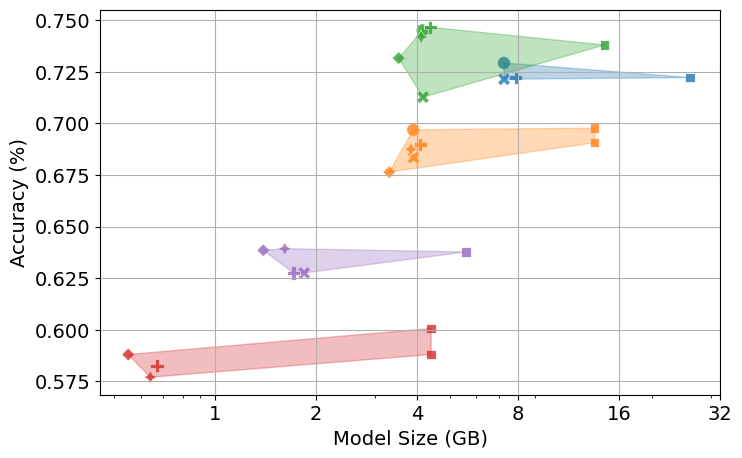

arc


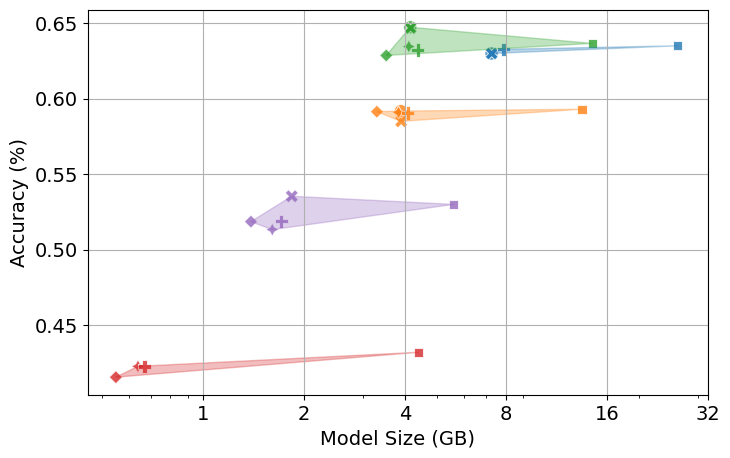

truthfulqa


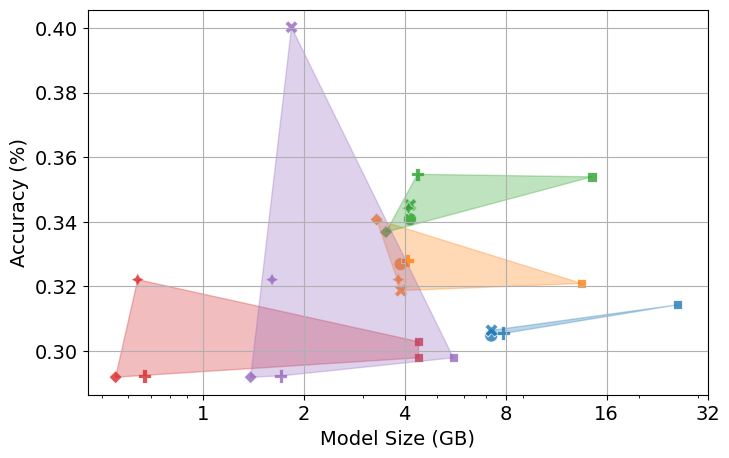

hellaswag


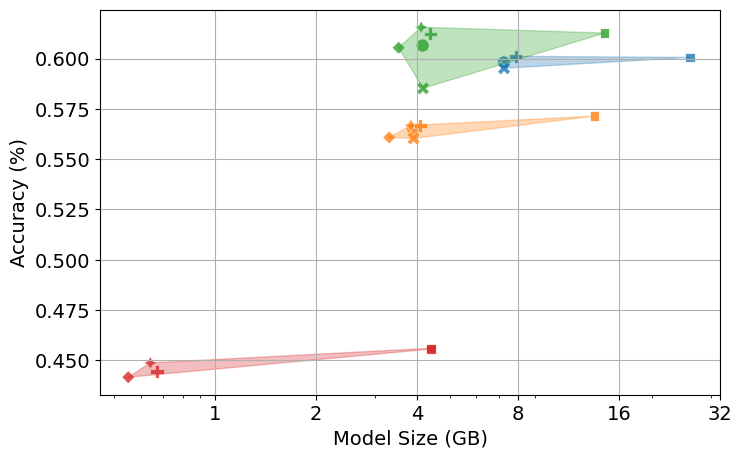

In [14]:
from scipy.spatial import ConvexHull
import numpy as np

datasets = ["winogrande", "arc", "truthfulqa", "hellaswag"]
filtered_df = result_df[result_df["dataset"].isin(datasets)]
filtered_df = filtered_df[filtered_df["framework"] != "paper"]

total_datasets = len(datasets)
# Create a separate plot for each dataset
for i, dataset in enumerate(datasets):
  print(dataset)
  dataset_df = filtered_df[filtered_df["dataset"] == dataset]
  dataset_df = dataset_df.merge(specs_df, on=("model","quantization"))
  dataset_df = dataset_df.sort_values(by=["model", "quantization"])

  # Create a single plot for the model in the dataset
  plt.figure(figsize=(8,5))
  ax = sns.scatterplot(x="size", y="accuracy", hue="model", style="quantization", data=dataset_df,
                       s=90, alpha=0.8)

  # Draw convex hulls for each model
  models = dataset_df["model"].unique()
  sorted_models = sorted(models)
  for model in sorted_models:
    model_df = dataset_df[dataset_df["model"] == model]
    points = model_df[["size", "accuracy"]].values
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = np.append(hull_points, hull_points[0:1], axis=0)

    color = sns.color_palette("tab10")[sorted_models.index(model)]
    ax.fill(hull_points[:, 0], hull_points[:, 1], color=to_rgba(color, 0.3))

  # ax.set_title(f"{dataset}: Performance vs Model Size")
  ax.set_xlabel("Model Size (GB)")
  ax.set_ylabel("Accuracy (%)")
  ax.set_xscale('log')
  xticks = [1, 2, 4, 8, 16, 32]
  xticklabels = [f"{size}" if size != 0.5 else "½" for size in xticks]
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels, rotation=0)
  # ax.set_xlim(-0, xticks[-1])
  if dataset == 'arc_easy':
    ax.legend(prop={'size': 11}, ncol=2, loc="upper left",
              columnspacing=-0.3, bbox_to_anchor=(-0.01, 1.015))
  else:
    ax.get_legend().remove()
  ax.grid()
  plt.savefig(f"figures/{dataset}_performance_vs_size.pdf", dpi=300, bbox_inches='tight')
  plt.show()

In [7]:
# Configure pd display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

,framework,model,dataset,quantization,accuracy,std_err
0,paper,Llama-2-7b,winogrande,None,0.692,None
1,paper,Llama-2-7b,arc_easy,None,0.752,None
2,paper,Llama-2-7b,arc_challenge,None,0.459,None
3,paper,Llama-2-7b,truthfulqa_mc,None,0.3329,None
4,paper,Llama-2-7b,hellaswag,None,0.772,None
5,paper,Mistral-7b-v0.1,winogrande,None,0.753,None
6,paper,Mistral-7b-v0.1,arc_easy,None,0.8,None
7,paper,Mistral-7b-v0.1,arc_challenge,None,0.555,None
8,paper,Mistral-7b-v0.1,truthfulqa_mc,None,None,None
9,paper,Mistral-7b-v0.1,hellaswag,None,0.813,None


,model,quantization,size,size_in_memory,parameters,max_ram,framework
0,Mistral-7b-v0.1,None,14.48,13.49,7240000,None,pytorch
1,Mistral-7b-v0.1,q3_k,3.52,3.28,7240000,6.02,llamacpp
2,Mistral-7b-v0.1,q4_k,4.37,4.07,7240000,6.87,llamacpp
3,Mistral-7b-v0.1,q4_0,4.11,3.83,7240000,6.61,llamacpp
4,Mistral-7b-v0.1,AWQ,4.15,4.47,7240000,None,pytorch
5,Mistral-7b-v0.1,GPTQ,4.16,4.47,7240000,None,pytorch
6,Llama-2-7b,None,13.50,12.55,6740000,None,pytorch
7,Llama-2-7b,q3_k,3.30,3.07,6740000,5.8,llamacpp
8,Llama-2-7b,q4_k,4.08,3.80,6740000,6.58,llamacpp
9,Llama-2-7b,q4_0,3.83,3.56,6740000,6.33,llamacpp


In [9]:
result_df.framework.unique()
result_df.quantization.unique()

array(['None', 'q2_k', 'q3_k', 'q4_k', 'q4_0', 'q0f16', 'q0f32', 'AWQ',
       'GPTQ'], dtype=object)

In [10]:
specs_df.quantization.unique()

array(['None', 'q3_k', 'q4_k', 'q4_0', 'AWQ', 'GPTQ'], dtype=object)

In [11]:
mapping_quant_framework = {
    "q3_k": "llamacpp",
    "q4_0": "llamacpp",
    "q4_k": "llamacpp",
    "AWQ": "pytorch",
    "GPTQ": "pytorch",
    "None": "pytorch"
}
specs_df["framework"] = specs_df["quantization"].map(mapping_quant_framework)
specs_df

,model,quantization,size,size_in_memory,parameters,max_ram,framework
0,Mistral-7b-v0.1,None,14.48,13.49,7240000,None,pytorch
1,Mistral-7b-v0.1,q3_k,3.52,3.28,7240000,6.02,llamacpp
2,Mistral-7b-v0.1,q4_k,4.37,4.07,7240000,6.87,llamacpp
3,Mistral-7b-v0.1,q4_0,4.11,3.83,7240000,6.61,llamacpp
4,Mistral-7b-v0.1,AWQ,4.15,4.47,7240000,None,pytorch
5,Mistral-7b-v0.1,GPTQ,4.16,4.47,7240000,None,pytorch
6,Llama-2-7b,None,13.50,12.55,6740000,None,pytorch
7,Llama-2-7b,q3_k,3.30,3.07,6740000,5.8,llamacpp
8,Llama-2-7b,q4_k,4.08,3.80,6740000,6.58,llamacpp
9,Llama-2-7b,q4_0,3.83,3.56,6740000,6.33,llamacpp


In [12]:
merged_df = result_df.merge(specs_df, on=("model", "quantization"))
display(merged_df.head(5))

,framework_x,model,dataset,quantization,accuracy,std_err,size,size_in_memory,parameters,max_ram,framework_y
0,paper,Llama-2-7b,winogrande,None,0.692,None,13.5,12.55,6740000,None,pytorch
1,paper,Llama-2-7b,arc_easy,None,0.752,None,13.5,12.55,6740000,None,pytorch
2,paper,Llama-2-7b,arc_challenge,None,0.459,None,13.5,12.55,6740000,None,pytorch
3,paper,Llama-2-7b,truthfulqa_mc,None,0.3329,None,13.5,12.55,6740000,None,pytorch
4,paper,Llama-2-7b,hellaswag,None,0.772,None,13.5,12.55,6740000,None,pytorch


In [13]:
result_df[(result_df.quantization == "None") & (result_df.framework != 'paper') & (result_df.framework == 'pytorch')]

,framework,model,dataset,quantization,accuracy,std_err
11,pytorch,Llama-2-7b,arc_easy,None,0.763,None
17,pytorch,Llama-2-7b,winogrande,None,0.6906,None
22,pytorch,Llama-2-7b,truthfulqa,None,0.3209,None
26,pytorch,Llama-2-7b,truthfulqa_mc_1,None,0.2521,0.0152
27,pytorch,Llama-2-7b,truthfulqa_mc_2,None,0.3897,0.0136
34,pytorch,Llama-2-7b,hellaswag,None,0.5714,0.0049
38,pytorch,Mistral-7b-v0.1,arc_easy,None,0.8089,0.0081
42,pytorch,Mistral-7b-v0.1,winogrande,None,0.738,0.0124
46,pytorch,Mistral-7b-v0.1,truthfulqa,None,0.3539,None
50,pytorch,Mistral-7b-v0.1,truthfulqa_mc_1,None,0.2815,0.0157


In [14]:
display(result_df[(result_df.quantization == "None") & (result_df.framework != 'paper')].head(10))
display(specs_df[specs_df.quantization == "None"].head(10))

,framework,model,dataset,quantization,accuracy,std_err
10,llamacpp,Llama-2-7b,arc_easy,None,0.7567,None
11,pytorch,Llama-2-7b,arc_easy,None,0.763,None
16,llamacpp,Llama-2-7b,winogrande,None,0.6977,None
17,pytorch,Llama-2-7b,winogrande,None,0.6906,None
22,pytorch,Llama-2-7b,truthfulqa,None,0.3209,None
26,pytorch,Llama-2-7b,truthfulqa_mc_1,None,0.2521,0.0152
27,pytorch,Llama-2-7b,truthfulqa_mc_2,None,0.3897,0.0136
34,pytorch,Llama-2-7b,hellaswag,None,0.5714,0.0049
38,pytorch,Mistral-7b-v0.1,arc_easy,None,0.8089,0.0081
42,pytorch,Mistral-7b-v0.1,winogrande,None,0.738,0.0124


,model,quantization,size,size_in_memory,parameters,max_ram,framework
0,Mistral-7b-v0.1,None,14.48,13.49,7240000,None,pytorch
6,Llama-2-7b,None,13.50,12.55,6740000,None,pytorch
12,Llama-2-13b,None,26.03,25.03,13000000,None,pytorch
16,TinyLlama-1.1B-v0.5,None,4.40,4.10,1100000,None,pytorch
20,Zephyr-3b,None,5.59,5.37,2800000,None,pytorch


In [15]:
merged_df[merged_df.quantization == "None"].model.unique()

array(['Llama-2-7b', 'Mistral-7b-v0.1', 'TinyLlama-1.1B-v0.5',
       'Zephyr-3b', 'Llama-2-13b'], dtype=object)

In [16]:
# turn all floats to use 2 decimal places and display only that to string
acc_size_df_all = merged_df.groupby(["model", "quantization", "size_in_memory", "dataset", ])[["accuracy"]].sum()
# display(acc_size_df_all)


for model, group_df in acc_size_df_all.groupby("model").groups.items():
  display(model)
  cols = ['size_in_memory', 'accuracy']
  df_of_interest = acc_size_df_all.loc[group_df].reset_index()[["quantization", "size_in_memory", "dataset", "accuracy"]]
  df_of_interest[cols] = df_of_interest[cols].replace("None", np.nan)
  df_of_interest[cols] = df_of_interest[cols].astype(np.double).applymap(lambda x: f"{x:.2f}" if x else 'None')
  df_of_interest.set_index(["quantization", "size_in_memory", "dataset"], inplace=True)

  with open(f"acc_size_df_{model}.tex", "w") as f:
    f.write(df_of_interest.to_latex().replace('_', '\_'))

with open("acc_size_df_all.tex", "w") as f:
  f.write(acc_size_df_all.to_latex().replace('_', '\_'))

'Llama-2-13b'

/var/folders/m6/kw74nlzd53j7nf5_4l969_0c0000gn/T/ipykernel_47541/1962608046.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_of_interest[cols] = df_of_interest[cols].astype(np.double).applymap(lambda x: f"{x:.2f}" if x else 'None')


'Llama-2-7b'

/var/folders/m6/kw74nlzd53j7nf5_4l969_0c0000gn/T/ipykernel_47541/1962608046.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_of_interest[cols] = df_of_interest[cols].astype(np.double).applymap(lambda x: f"{x:.2f}" if x else 'None')


'Mistral-7b-v0.1'

/var/folders/m6/kw74nlzd53j7nf5_4l969_0c0000gn/T/ipykernel_47541/1962608046.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_of_interest[cols] = df_of_interest[cols].astype(np.double).applymap(lambda x: f"{x:.2f}" if x else 'None')


'TinyLlama-1.1B-v0.5'

/var/folders/m6/kw74nlzd53j7nf5_4l969_0c0000gn/T/ipykernel_47541/1962608046.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_of_interest[cols] = df_of_interest[cols].astype(np.double).applymap(lambda x: f"{x:.2f}" if x else 'None')


'Zephyr-3b'

/var/folders/m6/kw74nlzd53j7nf5_4l969_0c0000gn/T/ipykernel_47541/1962608046.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_of_interest[cols] = df_of_interest[cols].astype(np.double).applymap(lambda x: f"{x:.2f}" if x else 'None')
